In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from functools import partial
import numpy as np
import math
import cv2
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
data_dir = "/content/drive/MyDrive/TT/data"
BATCH_SIZE = 16
IMAGE_SIZE = [640, 640]
AUTOTUNE = tf.data.AUTOTUNE
GRID_SIZE = 80

In [ ]:
train_filenames = tf.io.gfile.glob(data_dir + "/train*")
val_filenames = tf.io.gfile.glob(data_dir + "/test*")
raw_train = tf.data.TFRecordDataset(train_filenames)

In [ ]:
def decode_image(image):
    image = tf.io.decode_jpeg(image, channels=1)
    image = tf.cast(image, tf.uint8)
    image = tf.reshape(image, [*IMAGE_SIZE])
    return image

In [ ]:
def bbox_gen(x1, y1, x2, y2):
    x1 = x1.numpy().tolist()
    x2 = x2.numpy().tolist()
    y1 = y1.numpy().tolist()
    y2 = y2.numpy().tolist()
    Y = np.zeros((8, 8, 5), dtype=np.float32)
    for i in range(len(x1)):
        mx, my = math.floor((x1[i]*640) // GRID_SIZE), math.floor((y1[i]*640) // GRID_SIZE)
        if mx == 8:
            mx = 7
        if my == 8:
            my = 7
        channels = Y[my][mx]
        channels[0] = 1.0
        channels[1] = math.floor(x1[i]*640) - (mx*GRID_SIZE)
        channels[2] = math.floor(y1[i]*640) - (my*GRID_SIZE)
        channels[3] = math.floor(x2[i]*640) - (mx*GRID_SIZE)
        channels[4] = math.floor(y2[i]*640) - (my*GRID_SIZE)
    return Y

In [ ]:
def read_tfrecord(example):
    tfrecord_format = (
    {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width':  tf.io.FixedLenFeature([], tf.int64),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/source_id': tf.io.FixedLenFeature([], tf.string),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/format': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/xmin': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
        'image/object/bbox/xmax': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
        'image/object/bbox/ymin': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
        'image/object/bbox/ymax': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
    })
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image/encoded"])
    x1 = example['image/object/bbox/xmin']
    x2 = example['image/object/bbox/xmax']
    y1 = example['image/object/bbox/ymin']
    y2 = example['image/object/bbox/ymax']
    bboxes = tf.py_function(func=bbox_gen, inp=[x1, y1, x2, y2], Tout=tf.float32)
    return image, bboxes

In [ ]:
def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord), num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

In [ ]:
def get_dataset(filenames):
    dataset = load_dataset(filenames)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [ ]:
train = get_dataset(train_filenames)
val = get_dataset(val_filenames)

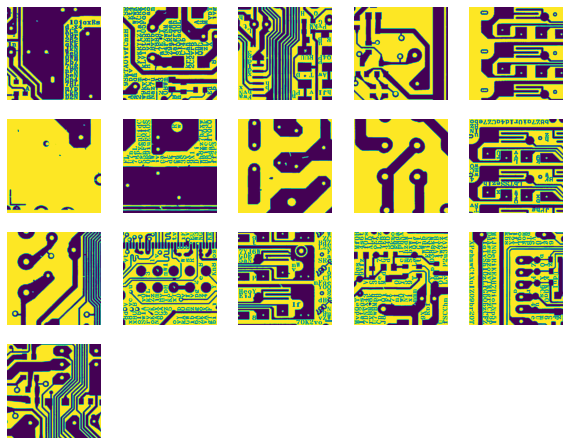

In [ ]:
image_batch = next(iter(train))

def show_batch(train_example):
    image_batch, ys = train_example
    image_batch = image_batch.numpy()
    #print(ys[0])
    plt.figure(figsize=(10, 10))
    for n in range(16):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n]/ 255.0)
        plt.axis("off")


show_batch(image_batch)

In [ ]:
x = x_input = tf.keras.layers.Input(shape=(640, 640, 1))

x = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.BatchNormalization()(x) # size: 320x320

x = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.BatchNormalization()(x)  # size: 160x160

x = tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=4)(x)
x = tf.keras.layers.BatchNormalization()(x)  # size: 40x40

x = tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=5)(x)
x = tf.keras.layers.BatchNormalization()(x) # size: 8x8x

# ---

x_prob = tf.keras.layers.Conv2D(1, kernel_size=3, padding='same', activation='sigmoid', name='x_prob')(x)
x_boxes = tf.keras.layers.Conv2D(4, kernel_size=3, padding='same', name='x_boxes')(x)

# ---

gate = tf.where(x_prob > 0.5, tf.ones_like(x_prob), tf.zeros_like(x_prob))
x_boxes = x_boxes * gate

# ---

x = tf.keras.layers.Concatenate()([x_prob, x_boxes])

model = tf.keras.models.Model(x_input, x)

In [ ]:
idx_p = [0]
idx_bb = [1, 2, 3, 4]

@tf.function
def loss_bb(y_true, y_pred):
    y_true = tf.gather(y_true, idx_bb, axis=-1)
    y_pred = tf.gather(y_pred, idx_bb, axis=-1)

    loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    return tf.reduce_mean(loss)

@tf.function
def loss_p(y_true, y_pred):
    y_true = tf.gather(y_true, idx_p, axis=-1)
    y_pred = tf.gather(y_pred, idx_p, axis=-1)
    
    loss = tf.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss)

@tf.function
def loss_func(y_true, y_pred):
    return loss_bb(y_true, y_pred) + loss_p(y_true, y_pred)

opt = tf.keras.optimizers.Adam(learning_rate=0.003)
model.compile(loss=loss_func, optimizer=opt)

In [ ]:
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self):
        super(EarlyStoppingAtMinLoss, self).__init__()
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get("loss")

        if current_loss <= 0.81:
            self.model.save('TTmodel_lt0.8.h5', overwrite=True)
            self.stopped_epoch = epoch
            self.model.stop_training = True

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


In [ ]:
best_weights_callback = tf.keras.callbacks.ModelCheckpoint(
    "training_1/cp.ckpt",
    monitor='loss',
    save_weights_only=True,
)

In [ ]:
history = model.fit(train, validation_data=val, epochs=50, callbacks=[EarlyStoppingAtMinLoss(), best_weights_callback])

Epoch 1/50
      6/Unknown - 4s 287ms/step - loss: 956.1342WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1191s vs `on_train_batch_end` time: 0.1394s). Check your callbacks.
235/235 [==============================] - 72s 298ms/step - loss: 251.9722 - val_loss: 134.6573
Epoch 2/50
235/235 [==============================] - 70s 296ms/step - loss: 91.4221 - val_loss: 90.1788
Epoch 3/50
235/235 [==============================] - 69s 295ms/step - loss: 53.1071 - val_loss: 61.2740
Epoch 4/50
235/235 [==============================] - 69s 295ms/step - loss: 30.0027 - val_loss: 28.9853
Epoch 5/50
235/235 [==============================] - 69s 295ms/step - loss: 25.4907 - val_loss: 19.9087
Epoch 6/50
235/235 [==============================] - 69s 295ms/step - loss: 13.9037 - val_loss: 13.7628
Epoch 7/50
235/235 [==============================] - 69s 294ms/step - loss: 11.1195 - val_loss: 12.4389
Epoch 8/50
235/235 [=====================

In [ ]:
def show_predict(X, y_true, threshold=0.7):
    X = X.numpy().copy()
    y = model.predict(X)
    plt.figure(figsize=(50,50))
    for n in range(16):
        Xrgb = cv2.cvtColor(X[n], cv2.COLOR_GRAY2RGB)
        y_pred = y[n]
        single_y_true = y_true.numpy()[n]

        ax = plt.subplot(4, 4, n + 1)
        plt.axis("off")
    
        for mx in range(8):
            for my in range(8):
                channels = y_pred[my][mx]
                channelst = single_y_true[my][mx]
                prob, x1, y1, x2, y2 = channels
                tprob, tx1, ty1, tx2, ty2 = channelst
                # if prob < threshold we won't show any thing
                if prob < threshold:
                    continue

                # bounding box pred
                px1, py1 = (mx * GRID_SIZE) + x1, (my * GRID_SIZE) + y1
                px2, py2 = (mx * GRID_SIZE) + x2, (my * GRID_SIZE) + y2
                cv2.rectangle(Xrgb, (int(px1), int(py1)), (int(px2), int(py2)), (255,0,0), 3)
                # bounding box true
                px1t, py1t = (mx * GRID_SIZE) + tx1, (my * GRID_SIZE) + ty1
                px2t, py2t = (mx * GRID_SIZE) + tx2, (my * GRID_SIZE) + ty2
                cv2.rectangle(Xrgb, (int(px1t), int(py1t)), (int(px2t), int(py2t)), (0,255,0), 2)
                #print(int(px), int(py), int(px + x2), int(py + y2))
        plt.imshow(Xrgb)

In [ ]:
image_batch, y = next(iter(val))

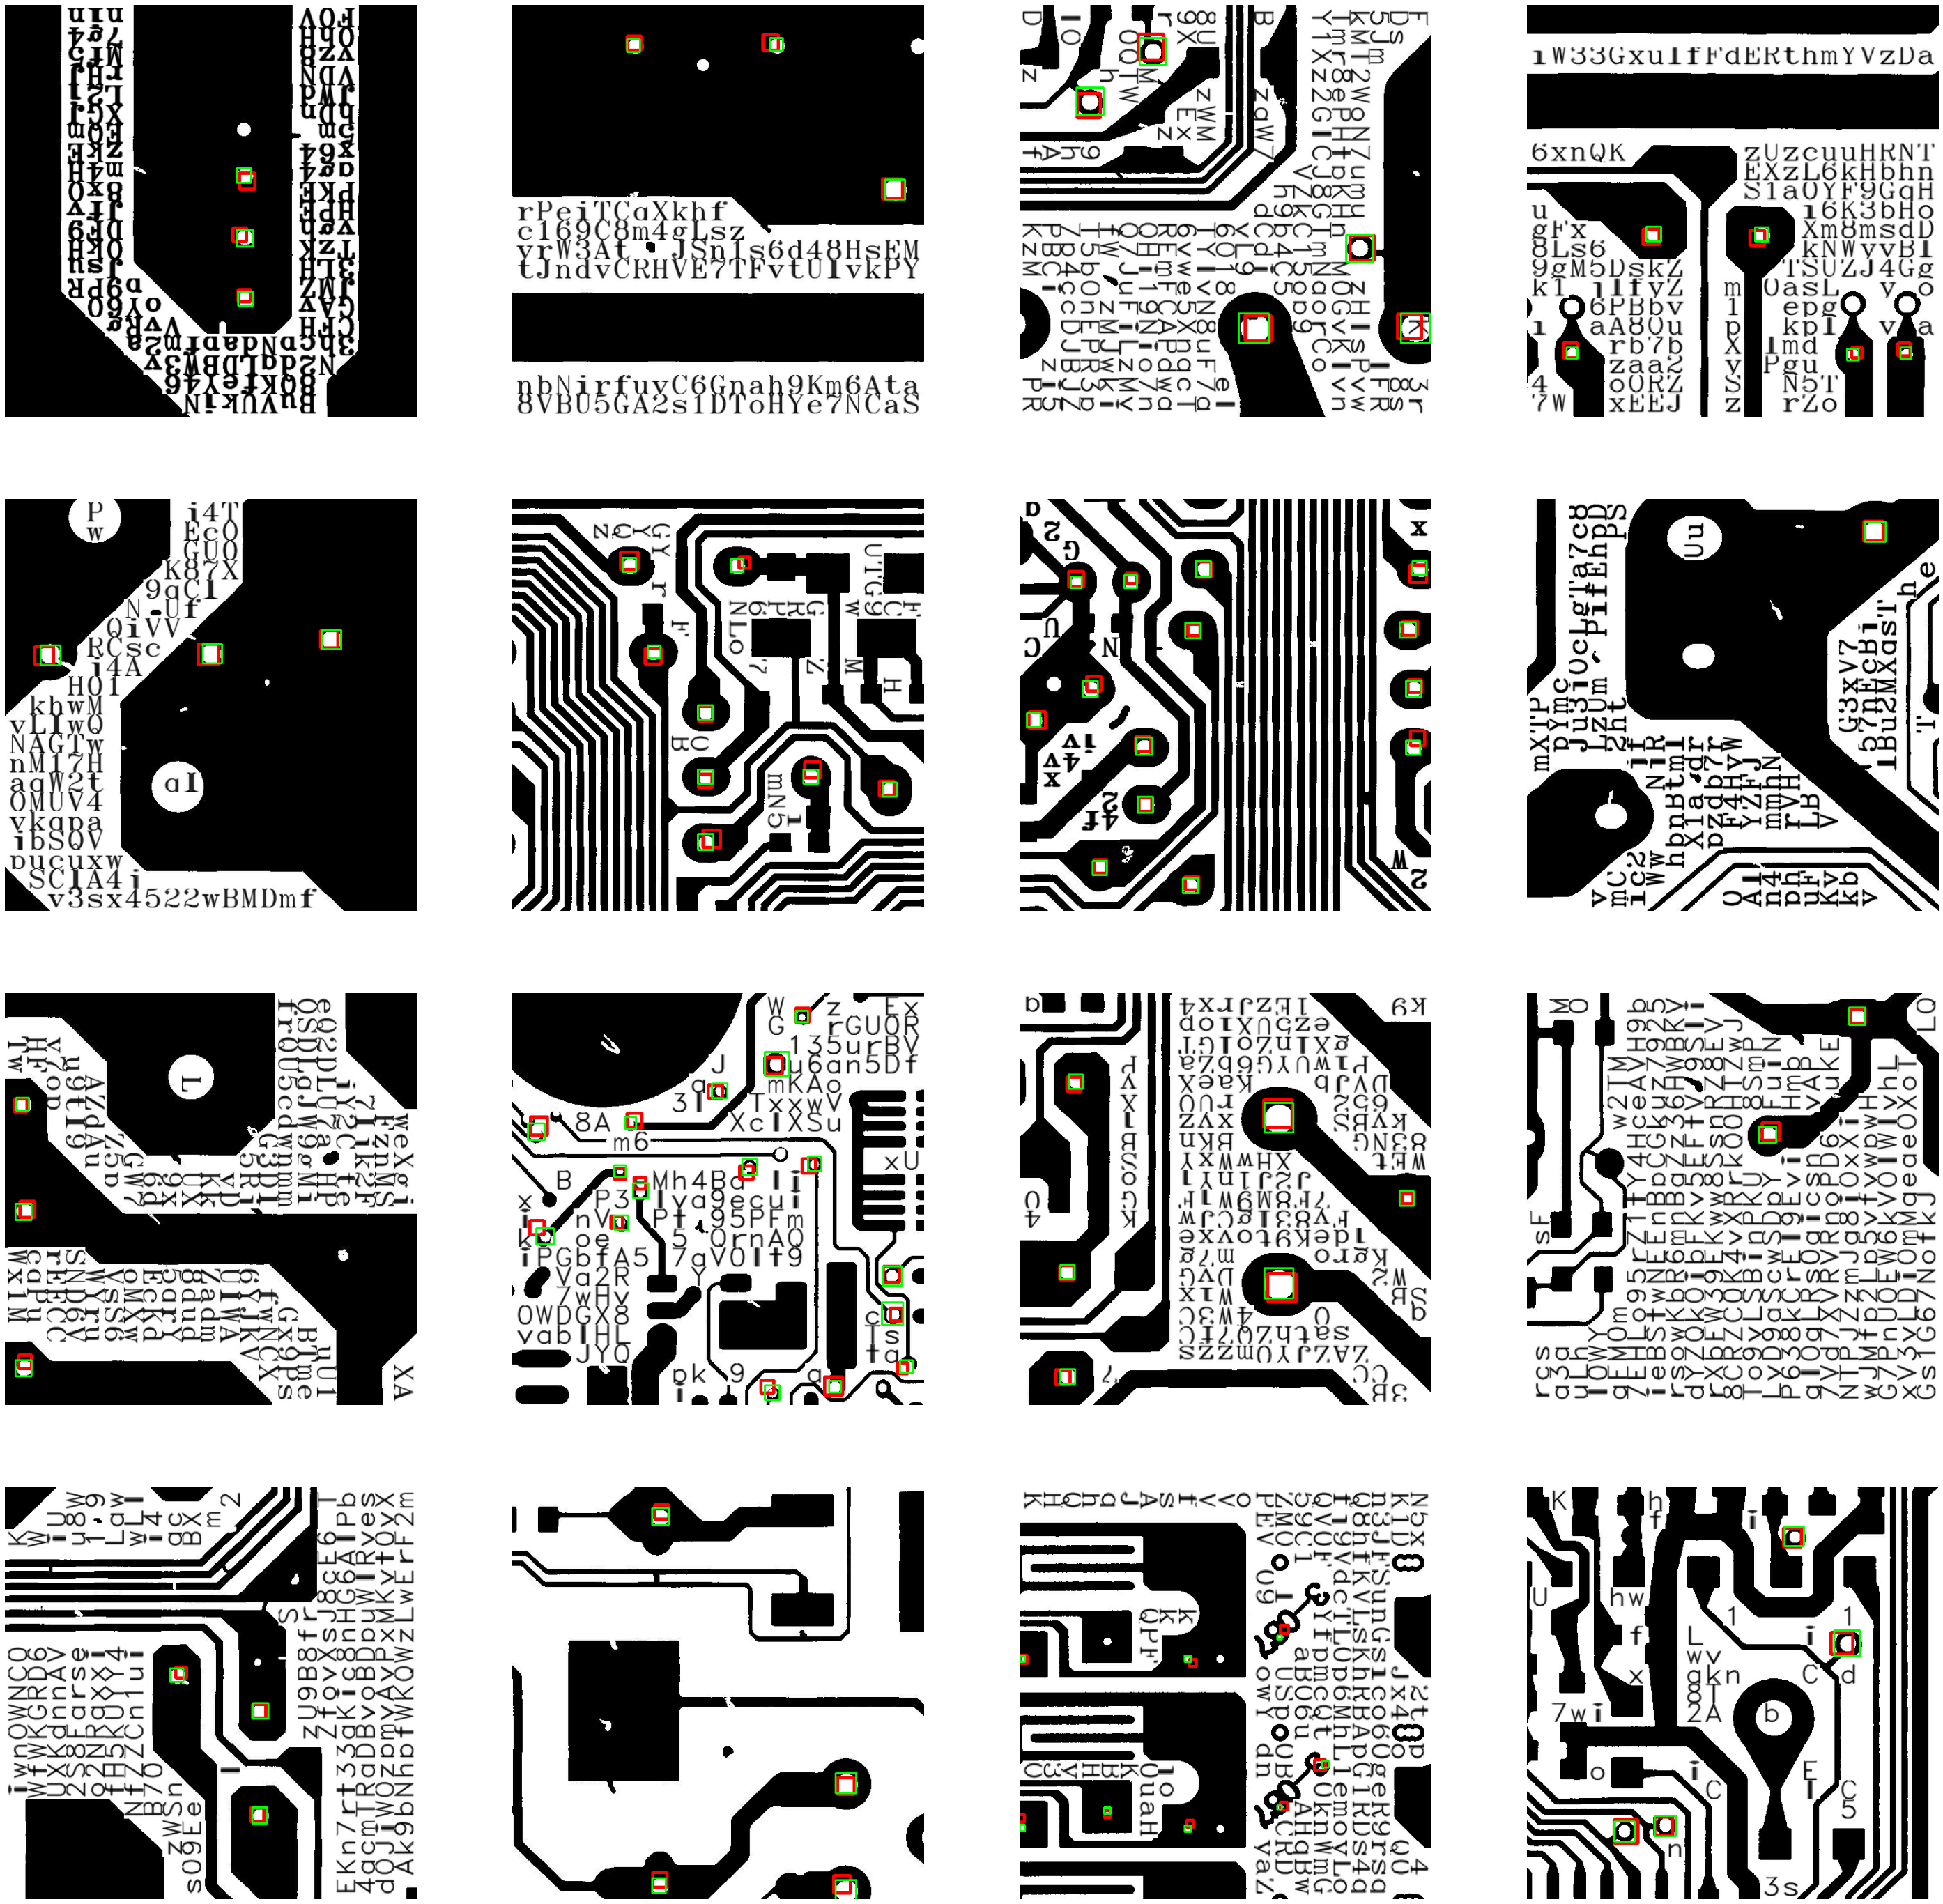

In [ ]:
show_predict(image_batch, y)

Text(0.5, 0, 'epoch')

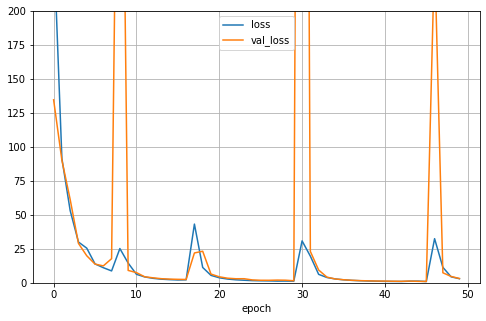

In [ ]:
import pandas as pd
# plotting the measurments in the history object
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 200)
plt.xlabel("epoch")